# Test Traffic Light Detector

Before opening this notebook, make sure PYTHONPATH is setup correctly for the TensorFlow Object Detection framework. E.g run:

`export PYTHONPATH=$PYTHONPATH:~/models/research:~/models/research/slim`

Some useful commands to train the detection model:
    
To train the model:

`python train.py --logtostderr --train_dir=./models/train --pipeline_config_path=<config>`

To export the model:

`python export_inference_graph.py --input_type image_tensor --pipeline_config_path <config> --trained_checkpoint_prefix ./models/train/model.ckpt-<num iterations> --output_directory ./frozen`

In [2]:
import numpy as np
import tensorflow as tf
import os
import sys
import glob
import cv2

from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

from keras.models import load_model

Using TensorFlow backend.


In [3]:
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

### Configuration Parameters

In [4]:
ENV='lot'   # !!! 'lot' or 'sim'
MODEL_NAME = 'ssd_inception_{}.pb'.format(ENV)
MODEL_BASEDIR = os.path.join('..', 'models')

PATH_TO_CKPT = os.path.join(MODEL_BASEDIR, MODEL_NAME)
PATH_TO_LABEL = os.path.join('detector', 'mscoco_label_map.pbtxt')

### Load the Tensorflow model into memory

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        
    input_image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    output_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    output_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    output_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    output_num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    
sess = tf.Session(graph=detection_graph)

### Helper functions

In [6]:
def load_image(path):
    image = mpimg.imread(path)
    image = (image * 255.0) / image.max()
    return image.astype(np.uint8)

In [7]:
def save_image(path, image):
    mpimg.imsave(path, image)

In [8]:
%matplotlib inline

def display_image(img):
    plt.figure()
    if len(img.shape) == 3 and img.shape[2] == 3:
        plt.imshow(img)
    elif len(img.shape) == 3 and img.shape[2] == 1:
        plt.imshow(img[:,:,0],cmap='gray')
    else:
        plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

### Detection

In [9]:
def get_detection(img):
    # bounding box detection.
    with detection_graph.as_default():
        # expand dimension since the model expects image to have shape [1, None, None, 3].
        img_expanded = np.expand_dims(img, axis=0)  
        (boxes, scores, classes, num) = sess.run(
            [output_boxes, output_scores, output_classes, output_num_detections],
            feed_dict={input_image_tensor: img_expanded})
        
    # all outputs are float32 numpy arrays, so convert types as appropriate
    num = int(num[0])
    classes = classes[0].astype(np.uint8)
    boxes = boxes[0]
    scores = scores[0]
        
    return boxes, scores, classes, num

In [11]:
label_map = label_map_util.load_labelmap(PATH_TO_LABEL)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

### Test detector on 1 image

[0.8397548  0.5422521  0.53075325]
[10 10 10]


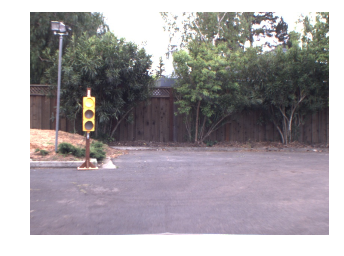

In [18]:
#img = load_image('test/sim/left0328.jpg')
img = load_image('test/lot/frame0140.jpg')

boxes, scores, classes, num = get_detection(img)
mask = (scores >= 0.50)

total = [scores[(scores >= 0.90) & (classes == 1)].sum(),
         scores[(scores >= 0.90) & (classes == 2)].sum(),
         scores[(scores >= 0.90) & (classes == 3)].sum()]
print (scores[mask])
print (classes[mask])

display_image(img)

### Test detector on multiple images

In [19]:
OUTDIR = 'test/done/'

for filename in tqdm(sorted(glob.glob('test/lot/*.jpg'))):
#for filename in tqdm(sorted(glob.glob('data_bosch/rgb/test/*.png'))):
    img = load_image(filename)
    
    boxes, scores, classes, num = get_detection(img)
    mask = (scores >= 0.70)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
          img,
          boxes[mask],
          classes[mask],
          scores[mask],
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
    
    save_image(OUTDIR + os.path.basename(filename) + '.jpg', img)
    

100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


### Test detector and classifier

In [20]:
classifier = load_model('../models/classifier_{}.h5'.format(ENV))

CLASS_NAMES = ['red', 'yellow', 'green', 'unknown']

test/lot/frame0140.jpg
red


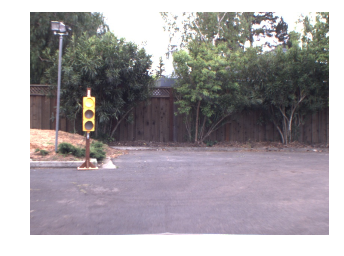

In [22]:
count = 0

for filename in sorted(glob.glob('test/lot/*jpg')):
        
    print (filename)
    img = load_image(filename)
        
    # classification
    boxes, scores, classes, num = get_detection(img)
    
    # filter
    mask = (scores >= 0.70) & (classes == 10)
    boxes, scores, classes = boxes[mask], scores[mask], classes[mask]
    
    lights = []
    
    # extract images
    for i in range(len(boxes)):
        top, left, bottom, right = int(boxes[i][0] * img.shape[0]), \
                                   int(boxes[i][1] * img.shape[1]), \
                                   int(boxes[i][2] * img.shape[0]), \
                                   int(boxes[i][3] * img.shape[1])
        
        light = img[top:bottom, left:right]
        light = cv2.resize(light, (32, 64))
        
        lights.append(light)
        
    # classify lights
    if (len(lights) <= 0):
        continue
    
    lights = np.array(lights)
    
    results = classifier.predict_on_batch(lights).sum(axis=0)
    class_id = np.argmax(results[0:3])
    if results[class_id] == 0:
        class_id = 3
    print(CLASS_NAMES[class_id])
    
   # vis_util.visualize_boxes_and_labels_on_image_array(
   #       img, boxes, classes, scores, category_index,
   #       use_normalized_coordinates=True, line_thickness=8)
    
    display_image(img)
    
    count = count + 1
    #if count > 20:
    #    break

### Extract traffic light images

In [24]:
count = 0
light_idx = 1

for filename in sorted(glob.glob('test/lot/*jpg')):
#for filename in sorted(glob.glob('data/lot/unknown/*jpg')):
    print (filename)
    img = load_image(filename)
    
    # classification
    boxes, scores, classes, num = get_detection(img)
    
    # filter
    mask = (scores >= 0.70) & (classes == 10)
    boxes, scores, classes = boxes[mask], scores[mask], classes[mask]
    
    # extract images
    for i in range(len(boxes)):
        top, left, bottom, right = int(boxes[i][0] * img.shape[0]), \
                                   int(boxes[i][1] * img.shape[1]), \
                                   int(boxes[i][2] * img.shape[0]), \
                                   int(boxes[i][3] * img.shape[1])
        
        light = img[top:bottom, left:right]
        light = cv2.resize(light, (32, 64))
        
        save_image('data_lights/sim/light_{:04d}.jpg'.format(light_idx), light)
        light_idx = light_idx + 1
        
    count = count + 1
    #if count > 10:
    #    break

test/lot/frame0140.jpg
